In [45]:
import cv2
import numpy as np
import time as t
from matplotlib import pyplot as plt
%matplotlib inline

In [377]:
def show(img, title=''):
    plt.title(title)
    plt.imshow(img, cmap="Greys_r")
    plt.show()
    
def thold(img):
    gimgmax = img.max(axis=1)[0]
    ret, thresh = cv2.threshold(img, gimgmax / 2, gimgmax, cv2.THRESH_BINARY)
    return thresh

# convolution
def convolution(img, ksize=3):
    kernel = np.ones((ksize, ksize), np.float32) / (ksize * ksize)
    cimg = cv2.filter2D(img, -1, kernel)
    return cimg

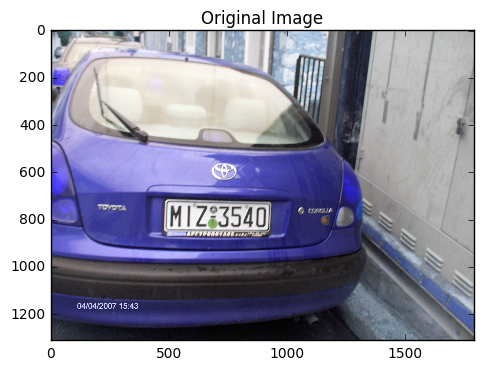

In [417]:
img = cv2.imread('/home/dorado/work/opencv/lpr/images/HPIM0719.JPG', 1)
show(img, 'Original Image')

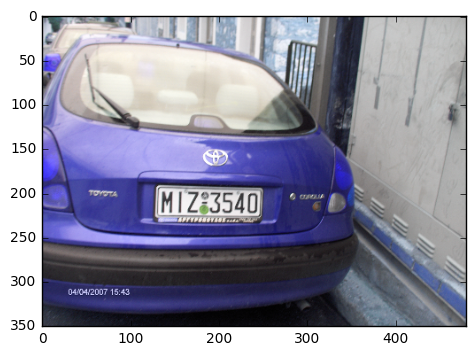

In [418]:
img = cv2.resize(img, (480, img.shape[0] * 480 / img.shape[1]))
show(img)

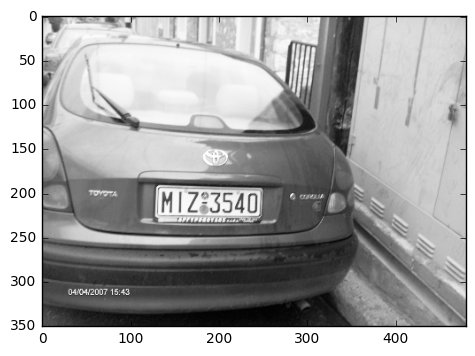

In [419]:
gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gimg, cmap="Greys_r")
plt.show()

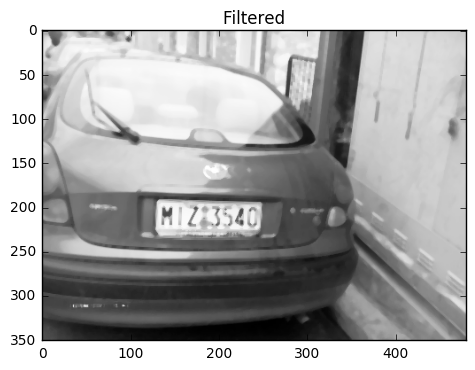

In [420]:
# bimg = cv2.GaussianBlur(gimg, (5, 5), 0)
# show(bimg)
mimg = cv2.medianBlur(gimg, 5)
show(mimg, 'Filtered')
bimg = mimg

In [421]:
def hor_and_ver_line_morph(img, ksize=5):
    strel_hor = np.ones(ksize, dtype=np.int)
    strel_ver = np.ones((ksize, 1), dtype=np.int)
    dil1 = cv2.morphologyEx(img, cv2.MORPH_ERODE, strel_hor)
#     show(dil1, 'Dil1')
    dil2 = cv2.morphologyEx(img, cv2.MORPH_ERODE, strel_ver)
#     show(dil2, 'Dil2')
    return dil2

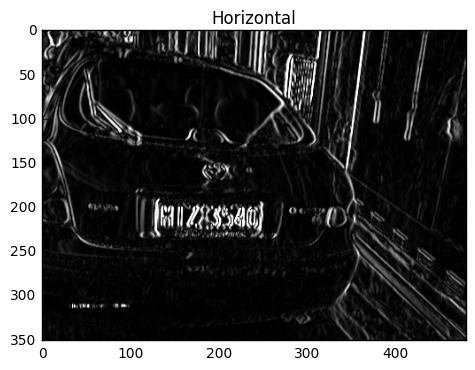

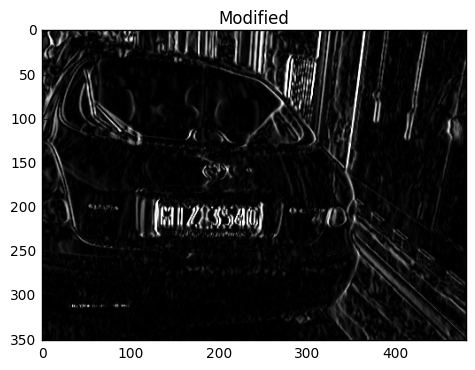

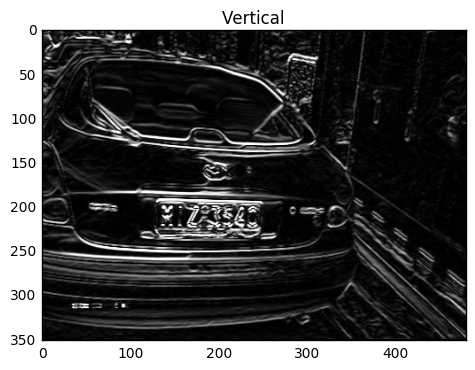

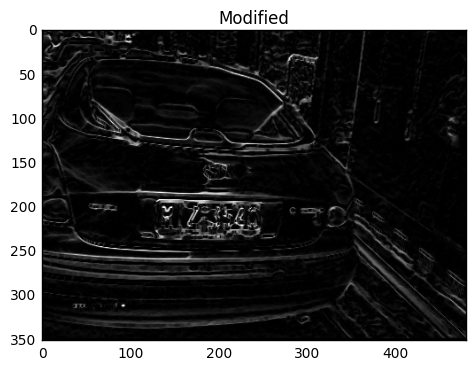

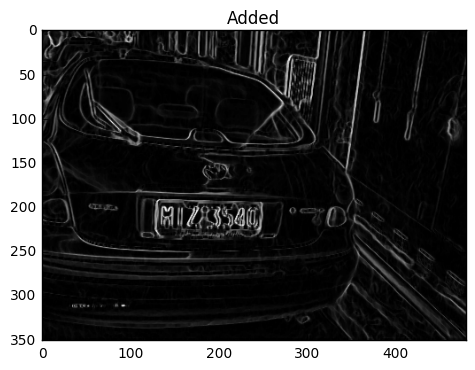

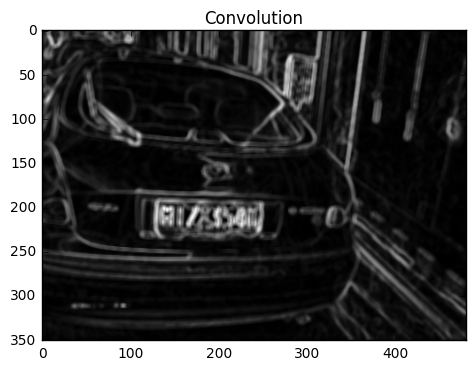

In [422]:
ddepth = cv2.CV_16S
sx = cv2.Sobel(bimg, ddepth, 1, 0, ksize = 3, borderType = cv2.BORDER_DEFAULT)
sy = cv2.Sobel(bimg, ddepth, 0, 1, ksize = 3, borderType = cv2.BORDER_DEFAULT)
absx = cv2.convertScaleAbs(sx)   # converting back to uint8
absy = cv2.convertScaleAbs(sy)
show(absx, 'Horizontal')
absx = hor_and_ver_line_morph(absx, 3)
show(absx, 'Modified')

show(absy, 'Vertical')
absy = hor_and_ver_line_morph(absy, 3)
show(absy, 'Modified')

edg = cv2.addWeighted(absx, 0.5, absy, 0.5, 0)
show(edg, 'Added')
edg = convolution(edg, ksize=5)
show(edg, 'Convolution')

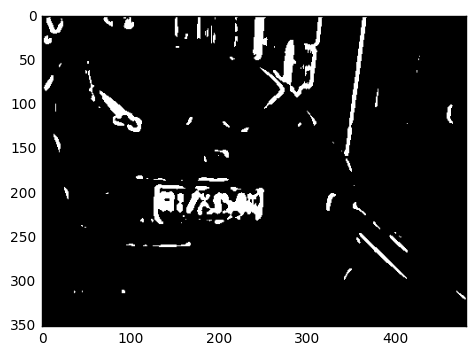

In [423]:
timg = thold(edg)
show(thold(edg))

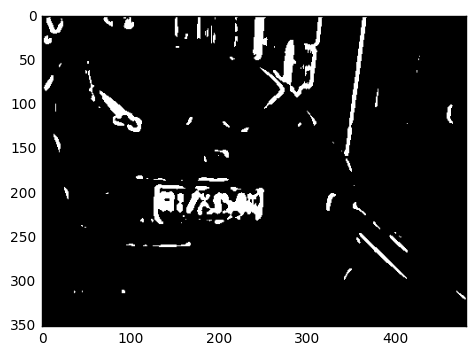

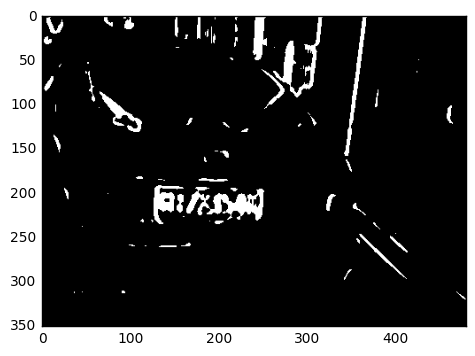

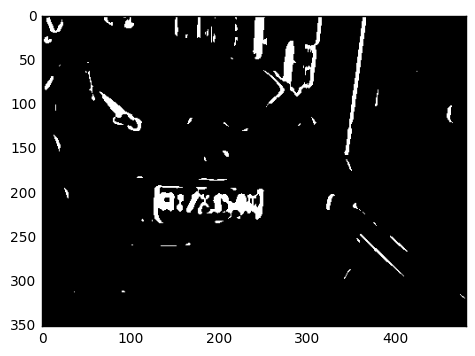

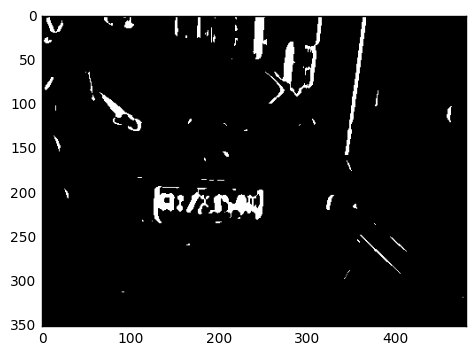

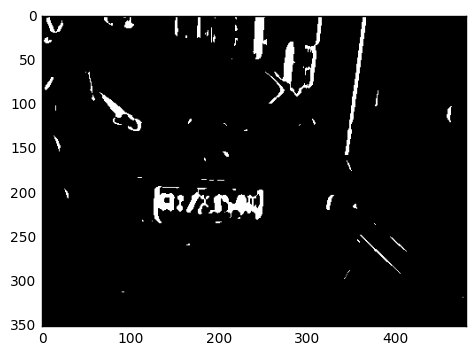

In [424]:
for i in range(1, 5):
    dil = hor_and_ver_line_morph(timg, i)
    show(dil)
show(dil)

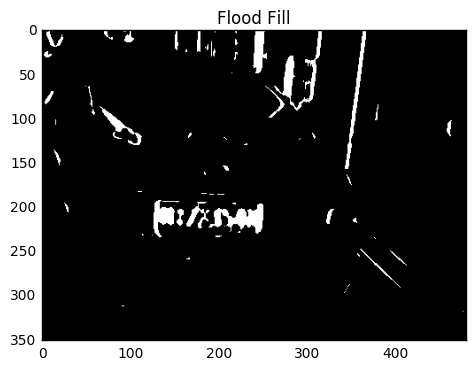

In [425]:
dil = dil
ff = dil.copy()
# Mask used to flood filling.
# Notice the size needs to be 2 pixels than the image.
h, w = dil.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
# Floodfill from point (0, 0)
cv2.floodFill(ff, mask, (0,0), 255);
# Invert floodfilled image
ffi = cv2.bitwise_not(ff)
# Combine the two images to get the foreground.
ffr = dil | ffi
show(ffr, 'Flood Fill')

In [426]:
#### imclearborder definition

def imclearborder(imgBW, radius):

    # Given a black and white image, first find all of its contours
    imgBWcopy = imgBW.copy()
    contours,hierarchy = cv2.findContours(imgBWcopy.copy(), cv2.RETR_LIST, 
        cv2.CHAIN_APPROX_SIMPLE)

    # Get dimensions of image
    imgRows = imgBW.shape[0]
    imgCols = imgBW.shape[1]    

    contourList = [] # ID list of contours that touch the border

    # For each contour...
    for idx in np.arange(len(contours)):
        # Get the i'th contour
        cnt = contours[idx]

        # Look at each point in the contour
        for pt in cnt:
            rowCnt = pt[0][1]
            colCnt = pt[0][0]

            # If this is within the radius of the border
            # this contour goes bye bye!
            check1 = (rowCnt >= 0 and rowCnt < radius) or (rowCnt >= imgRows-1-radius and rowCnt < imgRows)
            check2 = (colCnt >= 0 and colCnt < radius) or (colCnt >= imgCols-1-radius and colCnt < imgCols)

            if check1 or check2:
                contourList.append(idx)
                break

    for idx in contourList:
        cv2.drawContours(imgBWcopy, contours, idx, (0,0,0), -1)

    return imgBWcopy

#### bwareaopen definition
def bwareaopen(imgBW, areaPixels):
    # Given a black and white image, first find all of its contours
    imgBWcopy = imgBW.copy()
    contours,hierarchy = cv2.findContours(imgBWcopy.copy(), cv2.RETR_LIST, 
        cv2.CHAIN_APPROX_SIMPLE)

    # For each contour, determine its total occupying area
    for idx in np.arange(len(contours)):
        area = cv2.contourArea(contours[idx])
        if (area >= 0 and area <= areaPixels):
            cv2.drawContours(imgBWcopy, contours, idx, (0,0,0), -1)

    return imgBWcopy

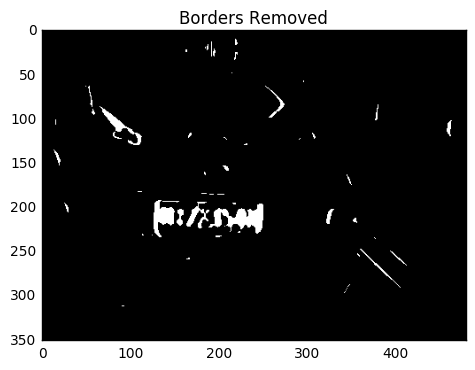

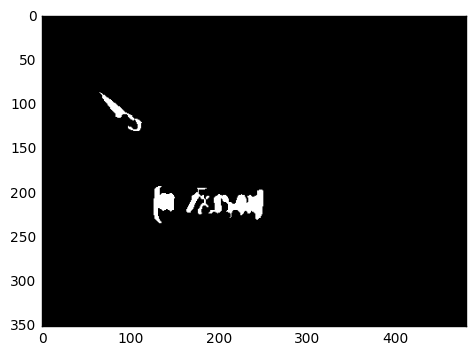

In [427]:
clear_border = imclearborder(ffr, 5)
show(clear_border, 'Borders Removed')
bwopen = bwareaopen(clear_border, 100)
show(bwopen)

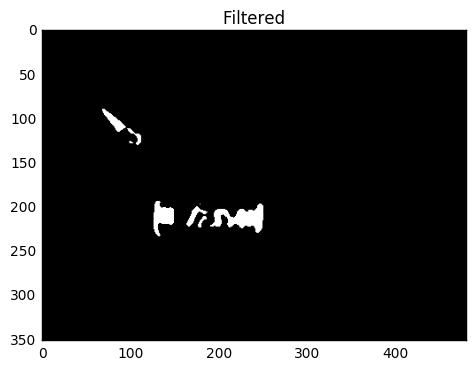

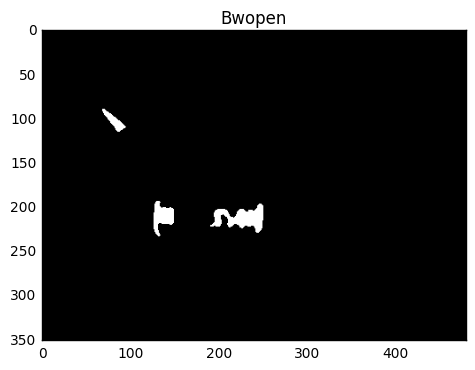

In [428]:
mimg = cv2.medianBlur(bwopen, 5)
show(mimg, 'Filtered')
bwopen = bwareaopen(mimg, 150)
show(bwopen, 'Bwopen')

[[0 1 0]
 [1 1 1]
 [0 1 0]]


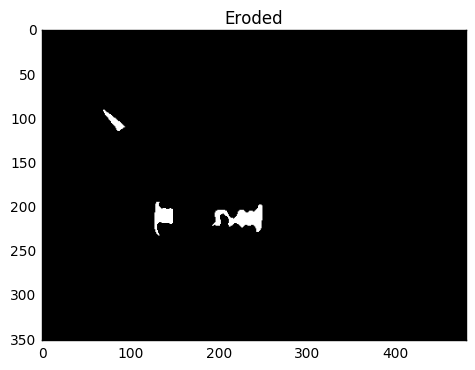

In [429]:
strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
print strel
erdimg = cv2.morphologyEx(bwopen, cv2.MORPH_ERODE, strel, iterations=1)
show(erdimg, 'Eroded')

3


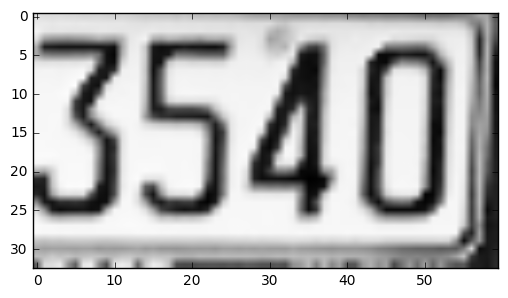

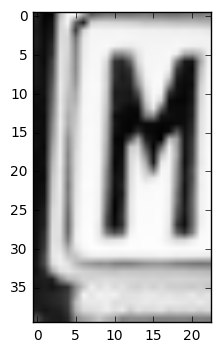

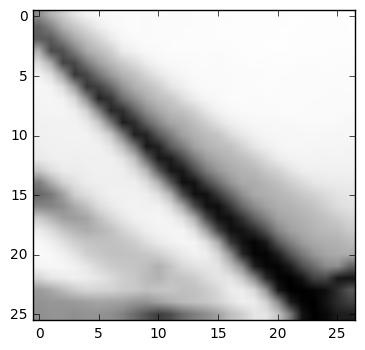

In [430]:
e_copy = np.array(bwopen)
contours, hierarchy = cv2.findContours(e_copy, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

print len(contours)

for c in contours:
    x, y, w, h = cv2.boundingRect(c)
#     cv2.rectangle(gimg, (x,y),(x+w,y+h),(0,255,0), 2)
    show(gimg[y:y+h, x:x+w])
#     show(gimg)